Setting up the Workspace

In [ ]:
!nvidia-smi

In [ ]:
# !mkdir 'data'
%cd /content/
!wget https://datasets.aicrowd.com/default/aicrowd-practice-challenges/public/autodri/v0.1/train.zip
!wget https://datasets.aicrowd.com/default/aicrowd-practice-challenges/public/autodri/v0.1/val.zip
!wget https://datasets.aicrowd.com/default/aicrowd-practice-challenges/public/autodri/v0.1/test.zip
!unzip train.zip
!unzip val.zip
!unzip test.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Moving vaidation data to train and selecting random sample


In [ ]:
%cd /content/
!mv /content/val/cameraFront/* '/content/train/cameraFront/'

/content


In [ ]:
import os
path = '/content/train/cameraFront/'
files =[f for f in os.listdir(path)]
print(len(files))
files.sort()
i = 0
for f in files[:2]:
  image = convert_to_grayscale(cv2.imread(path+f))
  cv2.imwrite(path+f,image)
  print(path+f)
  cv2_imshow(image)

Exploring the Dataset

In [ ]:
%cd /content/train/cameraFront
# %cd ..

/content/train/cameraFront


In [ ]:
import pandas as pd
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train = pd.read_csv('train.csv',dtype = {'filename': str})

In [ ]:
train.head(10)

,filename,canSteering
0,33856.jpg,180.000000
1,61909.jpg,-194.370014
2,36269.jpg,-39.000471
3,60259.jpg,-185.300714
4,50681.jpg,44.939983
5,29048.jpg,116.000000
6,9183.jpg,22.483047
7,49236.jpg,-504.000000
8,28372.jpg,96.000000
9,28747.jpg,-23.393333


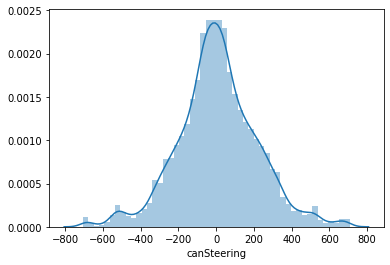

In [ ]:
sns.distplot(val['canSteering'])

In [ ]:
train = train.sort_values('filename')[6000:]
val = train.sort_values('filename')[:6000]

In [ ]:
train = train.sort_values('canSteering')

In [ ]:
val = train.iloc[::10, :]
drop_index = train.iloc[::10, :].index
train.drop(drop_index,axis=0,inplace=True)
print(train.shape)

(56425, 2)


In [ ]:
print(train.shape,val.shape)

(56425, 2) (6270, 2)


In [ ]:
print(train['canSteering'].max(),train['canSteering'].min())

708.219694 -705.2841080000003


In [ ]:
vis = train[train['canSteering']==0]['filename'].to_list()
print(len(vis))

135


In [ ]:
#Input size (225, 400, 3) -> change it (160,400,3)
cv2.imread(vis[0]).shape

# for i in range(100):
#   img = cv2.imread(vis[i])
#   print(img.shape)

(225, 400, 3)

In [ ]:
%cd ..
%cd cameraLeft/

/content/test
/content/test/cameraLeft


In [ ]:
%cd ..
%cd cameraRight/

/content/data/Autodri_dataset/train
/content/data/Autodri_dataset/train/cameraRight


In [ ]:
%cd train/
%cd cameraFront/

/content/train
/content/train/cameraFront


In [ ]:
%cd ..
%cd cameraRear/

/content/data/Autodri_dataset/train
/content/data/Autodri_dataset/train/cameraRear


In [ ]:
#Multi Image Vis

fig=plt.figure(figsize=(30, 30))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    rgb = plt.imread(vis[i])#[65:180,:]
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    gray =  cv2.merge((gray,gray,gray))

    gray = cv2.GaussianBlur(gray, (5, 5), 3)
    img = preprocess_input(gray)
    # img = img /255
    plt.imshow(cv2.resize(img,(224,224)))
    cv2_imshow(img)
plt.show()

In [ ]:
#Single Image vis

fig=plt.figure(figsize=(40, 40))

columns = 1
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(cv2.imread(vis))
plt.show()

In [ ]:
#normalize(-1,1)
min_value = -720
max_value = 720

def normalize(x):
  return 2*((x-min_value)/(max_value-min_value))-1

In [ ]:
train['canSteering'] = train['canSteering'].apply(lambda a: normalize(a))
val['canSteering'] = val['canSteering'].apply(lambda a: normalize(a))
train.head(10)

,filename,canSteering
23899,15398.jpg,-0.205556
33973,15399.jpg,-0.209853
35128,154.jpg,-0.011111
26258,1540.jpg,-0.100000
11219,15400.jpg,-0.206751
13812,15401.jpg,-0.205556
6170,15402.jpg,-0.216667
56526,15403.jpg,-0.205556
37799,15404.jpg,-0.221154
18663,15405.jpg,-0.222222


In [ ]:
print(train['canSteering'].max(),train['canSteering'].max())

0.9836384638888886 0.9836384638888886


#BaseLine Model Efficientnet B0 - 25000 MSE

In [ ]:
%pip install efficientnet

In [ ]:
!pip install git+https://github.com/qubvel/efficientnet

In [ ]:
from keras.applications.imagenet_utils import decode_predictions
import keras
# from efficientnet.keras import EfficientNetB0
# from efficientnet.keras import center_crop_and_resize, preprocess_input
from efficientnet.tfkeras import EfficientNetB0
from efficientnet.tfkeras import center_crop_and_resize, preprocess_input
# import tensorflow.keras.applications
# from efficientnet import EfficientNetB0
# from efficientnet import center_crop_and_resize, preprocess_input

In [ ]:
import json
import tensorflow as tf
import os
import keras
from tqdm import tqdm, tqdm_notebook
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense, Activation, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
print(vis[0])
img = cv2.imread(vis[0])
img = preprocess_input(img)
cv2_imshow(img)

In [ ]:
eff_net = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='avg',
    # classes=10,
    # classifier_activation="softmax"
)

In [ ]:
eff_net.trainable = False

In [ ]:
x = eff_net.output
x = Flatten()(x)
x = Dense(1280, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation="linear")(x)
model = Model(inputs = eff_net.input, outputs = predictions)
model.compile(tf.keras.optimizers.Adam(
    learning_rate=0.001,
),loss=tf.keras.losses.MeanSquaredError(),metrics=['mse','accuracy'])


In [ ]:
model.summary()

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='mse', factor=0.5, patience=2, verbose=1)

In [ ]:
filepath="/content/weights-improvement-{epoch:02d}.hdf5"
model_ckpt = ModelCheckpoint(
    filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode="min",
    save_freq=5,
)

In [ ]:
import os
files = [i for i in os.listdir()]
files.sort()
for i in files:
  img = img[65:180,:]
  img = cv2.GaussianBlur(img, (5, 5), 3)
  img = img /255
  img = cv2.resize(img,(224,224))
  cv2.imwrite(i,img)

In [ ]:
files = [i for i in os.listdir()]
files.sort()
print(files[0])

In [ ]:
%cd cameraFront

In [ ]:
def convert_to_grayscale(rgb):
  r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  gray =  cv2.merge((gray,gray,gray))
  img = cv2.GaussianBlur(gray, (5, 5), 3)
  # cv2_imshow(gray)
  img = preprocess_input(img)
  # cv2_imshow(img)
  # img = img[65:180,:]
  return cv2.resize(img,(224,224))

In [ ]:
def preprocess(img):
  return preprocess_input(img)

In [ ]:
datagen = ImageDataGenerator(
        # rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        # featurewise_center = True,
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,
        preprocessing_function = convert_to_grayscale,
        # validation_split=0.08,
        )

train_generator = datagen.flow_from_dataframe(
    testing,
    x_col="filename",
    y_col="canSteering",
    class_mode="raw",
    target_size=(224,224),
    batch_size=512
    # subset='training'
    # color_mode='rgb',
    )
valid_generator = datagen.flow_from_dataframe(
    val,
    x_col="filename",
    y_col="canSteering",
    class_mode="raw",
    target_size=(224,224),
    batch_size=256
    # subset='validation'
    # color_mode='rgb',
    )


Found 91657 validated image filenames.
Found 6270 validated image filenames.


In [ ]:
#View some images from the train generator
x, y = next(valid_generator)
fig=plt.figure(figsize=(30, 30))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  plt.imshow(x[i])
  # print(y[i],model.predict(x[i].reshape((1,224,224,3)))[0][0])
plt.show()
# print(x[0])
# print(x[0],y)
# print(x[0].shape)
# for i in range (0,50):
#     image = x[i]
#     # print(x[i].shape)
#     cv2_imshow(image)
#     print(image.shape)
#     image = image.reshape((1,224,224,3))
#     print(model.predict(image),y[i])
#     # plt.show()

In [ ]:
%cd train/cameraFront/

/content/train/cameraFront


In [ ]:
 model.fit_generator(train_generator,
                    validation_data = valid_generator,
                    callbacks=[reduce_lr],
                    shuffle=True,
                    epochs = 3,
                    verbose=1)

In [ ]:
model.save('/content/baseline_B0.h5')

In [ ]:
from google.colab import output
def sound():
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
sound()

In [ ]:
sound()
sound()

In [ ]:
%cd '/content/test/cameraFront'

/content/test/cameraFront


In [ ]:
files = [i for i in os.listdir()]
files.sort()
for i in files:
  img = cv2.imread(i)
  img = img[65:,:]
  cv2.imwrite(i,img)

In [ ]:
%cd ..
test = pd.read_csv('test.csv')
test.head(10)

In [ ]:
test['canSteering'] = test['filename'].apply(lambda a: prediction(a))

In [ ]:
%cd '/content/'

/content


In [ ]:
# test = pd.read_csv('test.csv',dtype={"canSteering":str})
# test['canSteering'] = test['canSteering'].apply(lambda a: a.replace('[', ''))
# test['canSteering'] = test['canSteering'].apply(lambda a: a.replace(']', ''))
# test.head(10)

In [ ]:
test.to_csv('test.csv', index=False)

In [ ]:
def prediction(i):
  img = cv2.imread('/content/test/cameraFront/'+i)
  print(i)
  number = model.predict(img.reshape(1,160,400,3))
  print(((number[0][0]-1)*(max_value - min_value))/2-min_value)
  return (((number[0][0]-1)*(max_value - min_value))/2-min_value)

In [ ]:
number = model.predict(cv2.imread('200.jpg').reshape(1,160,400,3))
print(((number[0][0]-1)*(max_value - min_value))/2-min_value)

In [ ]:
print(cv2.imread('33856.jpg').shape)

In [ ]:
max_value = 708.219694 
min_value = -705.2841080000003

#Resnet 50 Model


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import os

## Keras
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

import cv2
import pandas as pd
import random
import ntpath

## Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input

#Load the ResNet50 model
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in resnet.layers[:-4]:
    layer.trainable = False
 
 
for layer in resnet.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f31149ee908> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f3112accef0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f31149eea20> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f3112accb70> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f3112acc7b8> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f31149ee320> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f3112afac88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3112b49c18> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f3112b54ef0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f3112c2ce10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3112c2cc88> False
<tensorflow.python.keras.laye

In [ ]:
great_200 = train[train['canSteering']>200]

In [ ]:
less_200 = train[train['canSteering']<-200]

In [ ]:
testing = testing.append(less_200)

In [ ]:
testing.shape

(91657, 2)

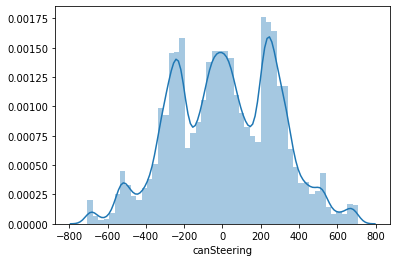

In [ ]:
sns.distplot(testing['canSteering'])

In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(resnet)

  model.add(Dropout(0.2))
  
  model.add(Flatten())
  
  model.add(Dense(5024, activation='elu'))
  model.add(Dropout(0.2))

  model.add(Dense(1024, activation='elu'))
  model.add(Dropout(0.2))

  model.add(Dense(512, activation='elu'))
  model.add(Dropout(0.2))
  
  model.add(Dense(128, activation='elu'))
  model.add(Dropout(0.2))
  
  model.add(Dense(64, activation='elu'))
  model.add(Dropout(0.2))
  
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.2))
  
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer, metrics=['mse','accuracy'])
  return model

In [ ]:
optimizer = Adam(lr=1e-4)
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer, metrics=['mse','accuracy'])
# return model

In [ ]:
%cd '/content/train/cameraFront/'

/content/train/cameraFront


In [ ]:
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 5024)              504173472 
_________________________________________________________________
dropout_1 (Dropout)          (None, 5024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              5145600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0

In [ ]:
model.fit_generator(train_generator,
                    validation_data = valid_generator,
                    callbacks=[reduce_lr],
                    shuffle=True,
                    epochs = 5,
                    verbose=1)

Epoch 1/5
180/180 [==============================] - 1281s 7s/step - loss: 75078.2188 - mse: 75078.2188 - accuracy: 6.3279e-04 - val_loss: 45361.7188 - val_mse: 45361.7188 - val_accuracy: 0.0000e+00
Epoch 2/5
180/180 [==============================] - 1315s 7s/step - loss: 75071.1719 - mse: 75071.1719 - accuracy: 5.5642e-04 - val_loss: 45358.4492 - val_mse: 45358.4492 - val_accuracy: 0.0000e+00
Epoch 3/5
180/180 [==============================] - 1307s 7s/step - loss: 75067.8359 - mse: 75067.8359 - accuracy: 2.6185e-04 - val_loss: 45355.5586 - val_mse: 45355.5586 - val_accuracy: 0.0000e+00
Epoch 4/5
180/180 [==============================] - 1311s 7s/step - loss: 75055.0391 - mse: 75055.0391 - accuracy: 1.0910e-04 - val_loss: 45352.2891 - val_mse: 45352.2891 - val_accuracy: 0.0000e+00
Epoch 5/5
128/180 [====================>.........] - ETA: 5:52 - loss: 74748.9375 - mse: 74748.9375 - accuracy: 1.5377e-05

In [ ]:
 !rm -r /content/variables

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model.save('/content/resnet50_bw_15_new1.h5')

In [ ]:
%cp '/content/resnet50_bw_15_new1.h5' '/content/drive/My Drive'

#Create submission

In [ ]:
%cd /content/
# !wget https://datasets.aicrowd.com/default/aicrowd-practice-challenges/public/autodri/v0.1/test.zip
# !unzip test.zip

/content


In [ ]:
# %cd ..
%cd test
test = pd.read_csv('test.csv')
test.head(5)

/content/test


,filename
0,0.jpg
1,1.jpg
2,2.jpg
3,3.jpg
4,4.jpg


In [ ]:
def prediction(i):
    rgb = cv2.imread('/content/test/cameraFront/'+i)
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    gray =  cv2.merge((gray,gray,gray))
    img = cv2.GaussianBlur(gray, (5, 5), 3)
    # print(img.shape)
    # img = img[65:180,:]
    img = cv2.resize(img,(224,224))
    # print(img.shape)
    img = preprocess_input(img)
    # cv2_imshow(img)
    number = model.predict(img.reshape(1,224,224,3))
    print(i,end=' ')
    # print(((max_value-min_value)*(number[0][0]+1)+2*min_value)/2,end=' ')
    # print(number[0][0])
    # return (((max_value-min_value)*(number[0][0]+1)+2*min_value)/2)
    print(number[0][0])
    return (number[0][0])

In [ ]:
min_value = -720
max_value = 720

In [ ]:
test['canSteering'] = test['filename'].apply(lambda a: prediction(a))

Streaming output truncated to the last 5000 lines.
16270.jpg -84.54739
16271.jpg -88.99373
16272.jpg -115.249535
16273.jpg -106.05254
16274.jpg -131.34549
16275.jpg -83.64133
16276.jpg -73.09635
16277.jpg -93.19503
16278.jpg -51.797466
16279.jpg -113.41907
16280.jpg -99.26247
16281.jpg -110.40675
16282.jpg -117.73923
16283.jpg -127.88016
16284.jpg -95.933304
16285.jpg -50.616524
16286.jpg -16.877434
16287.jpg -1.4590244
16288.jpg 36.122597
16289.jpg 61.562366
16290.jpg -16.83225
16291.jpg -79.96576
16292.jpg 20.450394
16293.jpg -65.54904
16294.jpg 46.583656
16295.jpg 2.6369104
16296.jpg 38.81295
16297.jpg 45.333195
16298.jpg 86.3649
16299.jpg 78.57452
16300.jpg 54.65916
16301.jpg 86.29383
16302.jpg 45.2632
16303.jpg 68.245285
16304.jpg 60.99752
16305.jpg 56.64512
16306.jpg 49.15435
16307.jpg 65.02493
16308.jpg 94.25304
16309.jpg 98.73861
16310.jpg 85.41819
16311.jpg 75.71615
16312.jpg 71.9417
16313.jpg 78.68161
16314.jpg 73.22799
16315.jpg 103.43305
16316.jpg 78.578285
16317.jpg 56.225

In [ ]:
test.to_csv('/content/test_15_res50_bw_uncropped.csv', index=False)

In [ ]:
from keras.models import Sequential, load_model
model = load_model('/content/resnet50_bw_10_new.h5')

In [ ]:
import imblearn

In [ ]:
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=128):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

In [ ]:
# x, y = ... # load your data
datagen = ImageDataGenerator()
balanced_gen = BalancedDataGenerator(x, y, datagen, batch_size=32)
steps_per_epoch = balanced_gen.steps_per_epoch
# model.fit_generator(balanced_gen, steps_per_epoch, ...)

NameError: ignored